# Develop Fixed-radius NN Linear-time Algorithm

Explore the techniques described in [this paper](https://reader.elsevier.com/reader/sd/pii/0020019077900709?token=E45C0E1870EA26C21C1F149B6090CE4630A51269D324BE1206B7BF2764FB48B2DDC93F4B86FBFBD8CBDED63B15BBC6DA&originRegion=us-east-1&originCreation=20210428165528).

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
from time import time as tt
import importlib

# External imports
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader

from itertools import chain
from random import shuffle, sample
from scipy.optimize import root_scalar as root

from torch.nn import Linear
import torch.nn.functional as F
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations
import itertools
from sklearn import metrics
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from torch.utils.checkpoint import checkpoint

import faiss

sys.path.append('/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/TrackML_Example')
device = "cuda" if torch.cuda.is_available() else "cpu"

## Prepare example data

In [6]:
d = 2                           # dimension
nb = 10000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).type(dtype)

## Explore Bentley algorithm

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from grispy import GriSPy

In [81]:
# Create random points and centres
Npoints = 10 ** 3
Ncentres = 2
dim = 2
Lbox = 100.0

In [82]:
np.random.seed(2)
data = np.random.uniform(0, Lbox, size=(Npoints, dim))
centres = np.random.uniform(0, Lbox, size=(Ncentres, dim))

In [83]:
# Grispy params
upper_radii = 15.0
lower_radii = 10.0
n_nearest = 100

In [84]:
%%time
gsp = GriSPy(data)

CPU times: user 6.48 ms, sys: 0 ns, total: 6.48 ms
Wall time: 5.91 ms


In [85]:
%%time
bubble_dist, bubble_ind = gsp.bubble_neighbors(
    data, distance_upper_bound=upper_radii
)

CPU times: user 580 ms, sys: 0 ns, total: 580 ms
Wall time: 579 ms


In [80]:
# Plot results
plt.figure(1, figsize=(10, 10))

plt.subplot(1, 1, 1, aspect="equal")
plt.title("Bubble query")
plt.scatter(data[:, 0], data[:, 1], c="k", marker=".", s=3)
for ind in bubble_ind:
    plt.scatter(data[ind, 0], data[ind, 1], c="C3", marker="o", s=5)
plt.plot(centres[:, 0], centres[:, 1], "ro", ms=10)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x2aaad73e7560> (for post_execute):


KeyboardInterrupt: 

In [58]:
bubble_ind

[array([9046, 6441, 2552, 4488, 6392, 3276, 6926, 2311, 2141, 4422, 6045,
        6775, 9279, 5958, 3956, 5619, 5543, 3178, 6859, 6189, 2840, 5347,
         919,   51, 7777, 8670, 2198, 7663, 1140, 1889, 6402, 8889,  624,
        3163, 1622, 6705, 5040, 1218, 4986, 8974, 2903, 9920, 9274, 4903,
        5620, 1473, 3989, 5145, 1337, 3975, 9035, 1002, 2586, 3191, 8598,
        3758, 5363, 7355, 5208, 5246, 9130, 4426, 5340, 1356, 2291, 9194,
        9280, 3328, 9560, 6222, 5105, 3021, 2911, 1101, 8286, 6227, 1045,
        7704, 7097, 6014, 4483, 3196, 8721, 3528,  810, 8655, 4051, 8050,
        9908, 1339, 7637, 5814, 5275, 6328, 2205, 8241,  416, 5831, 5121,
        2850, 1274, 5716, 2013, 2873, 5781, 2607, 7430, 6349, 3463, 6660,
        8392, 4268, 5788, 1489, 4688, 4250,  746, 8070,  784, 7882, 9606,
        5830, 3008, 3251, 6453,  499, 8860, 1792, 3512, 8993, 1404, 8127,
        7966, 7716, 7539, 7115, 4188, 8480, 7166, 4071, 1547, 7823, 7241,
        5328, 3060, 7889, 7684, 3692, 

## FAISS Radius/Dimension Scaling

### CPU

In [87]:
%%time
index = faiss.IndexFlatL2(dim)   # build the index
print(index.is_trained)
index.add(data.astype('float32'))                  # add vectors to the index
print(index.ntotal)

True
1000
CPU times: user 963 µs, sys: 352 µs, total: 1.32 ms
Wall time: 955 µs


In [88]:
%%time
D, I = index.search(data.astype('float32'), 500)

CPU times: user 75.6 ms, sys: 6.41 ms, total: 82 ms
Wall time: 165 ms


In [89]:
I

array([[  0, 411, 407, ..., 666, 328,  21],
       [  1, 421,  22, ..., 527, 366, 124],
       [  2, 734, 815, ...,  60, 533, 792],
       ...,
       [997,  21, 729, ..., 640, 249, 456],
       [998, 141, 864, ..., 385, 175, 459],
       [999, 561, 324, ..., 764,  36, 941]])

In [52]:
D

array([[0.0000000e+00, 4.6899414e-01, 7.0556641e-01, ..., 2.5530225e+02,
        2.5592188e+02, 2.5671094e+02],
       [0.0000000e+00, 2.9394531e-01, 3.1054688e-01, ..., 1.5174121e+02,
        1.5187500e+02, 1.5221289e+02],
       [0.0000000e+00, 1.3461914e+00, 1.5395508e+00, ..., 1.5487061e+02,
        1.5501611e+02, 1.5513818e+02],
       ...,
       [0.0000000e+00, 1.8261719e-01, 2.1875000e-01, ..., 1.6212793e+02,
        1.6213184e+02, 1.6234717e+02],
       [0.0000000e+00, 1.5121460e-01, 5.9133911e-01, ..., 2.9014709e+02,
        2.9033490e+02, 2.9083832e+02],
       [0.0000000e+00, 4.8828125e-03, 5.1562500e-01, ..., 2.5598438e+02,
        2.5611133e+02, 2.5708984e+02]], dtype=float32)

In [53]:
%%time
D_torch = torch.from_numpy(D)
I_torch = torch.from_numpy(I)

CPU times: user 55 µs, sys: 10 µs, total: 65 µs
Wall time: 68.9 µs


In [54]:
%%time
ind = torch.Tensor.repeat(
        torch.arange(I.shape[0], device='cpu'), (I.shape[1], 1), 1
    ).T
D_mask = D_torch <= upper_radii ** 2
edge_list = torch.stack([ind[D_mask], I_torch[D_mask]])

CPU times: user 288 ms, sys: 136 ms, total: 425 ms
Wall time: 255 ms


In [55]:
ind[D_mask].shape

torch.Size([4829241])

In [24]:
radius_graph = np.sum(D**2, axis=1) < upper_radii**2

array([False, False, False, ..., False, False, False])

### GPU

In [3]:
import faiss
import torch
import faiss.contrib.torch_utils

In [30]:
d = 2                           # dimension
r_max = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float()*L_box

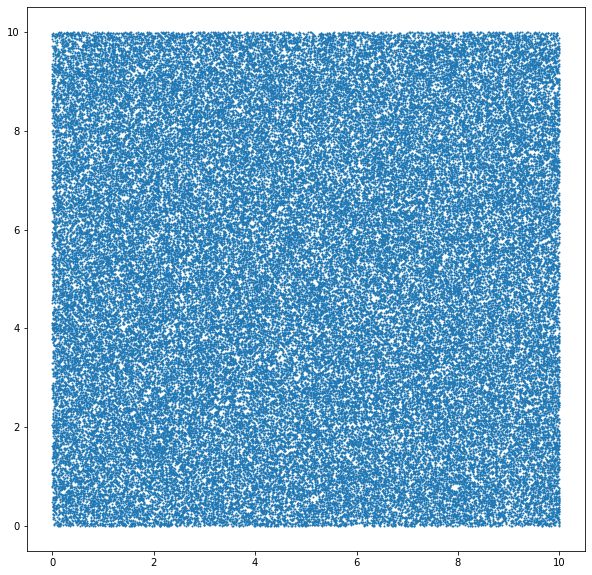

In [31]:
plt.figure(figsize=(10,10))
plt.scatter(xb[:, 0], xb[:, 1], s=1)

In [35]:
%%time
res = faiss.StandardGpuResources()
D, I = faiss.knn_gpu(res, xb, xb, 1000)

CPU times: user 1.5 s, sys: 1.1 s, total: 2.6 s
Wall time: 2.6 s


In [36]:
%%time
D, I = D.to(device), I.to(device)
ind = torch.Tensor.repeat(
        torch.arange(I.shape[0], device=device), (I.shape[1], 1), 1
).T
edge_list = torch.stack([ind[D <= r_max ** 2], I[D <= r_max ** 2]])

# Remove self-loops
edge_list = edge_list[:, edge_list[0] != edge_list[1]]

CPU times: user 281 ms, sys: 52 ms, total: 333 ms
Wall time: 332 ms


In [37]:
edge_list.shape

torch.Size([2, 99895043])

# Bentley From Scratch

1. Make grid
2. Hash the grid dictionary (?) Or is it faster to vectorize by keeping as a k-Array
3. Throw away empty grids
4. Build point neighbourhood array
5. Over neighbourhood array generate pairs 

In [3]:
from itertools import permutations, product

## Make Grid

In [44]:
d = 2                        # dimension
r_max = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device)

1. Grid size

In [45]:
%%time
x_cell_ref = (xb // r_max).int()

CPU times: user 94 µs, sys: 70 µs, total: 164 µs
Wall time: 169 µs


In [46]:
%%time
all_cells = torch.flatten(torch.stack(torch.meshgrid([torch.arange(L_box // r_max).to(device)]*d)), start_dim=1).T

CPU times: user 287 µs, sys: 216 µs, total: 503 µs
Wall time: 330 µs


In [66]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0, 1])]*d)), start_dim=1).T
exclusive_nhood = torch.cat([inclusive_nhood[:len(inclusive_nhood)//2], inclusive_nhood[len(inclusive_nhood)//2+1:]]).to(device)

Previous implementation

In [13]:
%%time
for cell in all_cells:
    x_in_cell = torch.where((x_cell_ref == cell).all(1))[0]
    length_list = torch.arange(len(x_in_cell)).to(device)
    in_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(length_list, length_list)), start_dim=1).T

CPU times: user 24.6 ms, sys: 431 µs, total: 25.1 ms
Wall time: 24.3 ms


In [81]:
%%time
for cell in all_cells:
    x_in_nhood = torch.where((x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).all(2).any(0))[0]
    nhood_length_list = torch.arange(len(x_in_nhood)).to(device)
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(length_list, nhood_length_list)), start_dim=1).T

CPU times: user 80.4 ms, sys: 8.31 ms, total: 88.7 ms
Wall time: 87.9 ms


Faster implementation

In [48]:
%%time
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    in_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_cell)), start_dim=1)

CPU times: user 15.3 ms, sys: 0 ns, total: 15.3 ms
Wall time: 14.6 ms


In [49]:
%%time
for cell in all_cells:
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1).T

CPU times: user 30.6 ms, sys: 2.83 ms, total: 33.4 ms
Wall time: 32.8 ms


In [98]:
%%time
in_cell_combinations = in_cell_combinations[:, in_cell_combinations[0] != in_cell_combinations[1]]

CPU times: user 302 µs, sys: 270 µs, total: 572 µs
Wall time: 365 µs


In [102]:
all_radius_edges = []

In [103]:
%%time
all_radius_edges.append(in_cell_combinations[:, torch.sum( (xb[in_cell_combinations[0]] - xb[in_cell_combinations[1]])**2, dim=1) < r_max**2])

CPU times: user 395 µs, sys: 364 µs, total: 759 µs
Wall time: 541 µs


Adding in distance calculation

In [68]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    in_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_cell)), start_dim=1)
    all_radius_edges.append(in_cell_combinations[:, torch.sum( (xb[in_cell_combinations[0]] - xb[in_cell_combinations[1]])**2, dim=1) < r_max**2])

CPU times: user 41.5 ms, sys: 0 ns, total: 41.5 ms
Wall time: 40.8 ms


In [54]:
%%time
for cell in all_cells:
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1).T
    all_radius_edges.append(out_cell_combinations[:, torch.sum( (xb[out_cell_combinations[0]] - xb[out_cell_combinations[1]])**2, dim=1) < r_max**2])

CPU times: user 51.7 ms, sys: 7.75 ms, total: 59.5 ms
Wall time: 58.9 ms


## Improvements

### Triangulate

In [55]:
d = 2                        # dimension
r_max = 1
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device)

# Assign grid cells
x_cell_ref = (xb // r_max).int()

# Build grid list
all_cells = torch.flatten(torch.stack(torch.meshgrid([torch.arange(L_box // r_max).to(device)]*d)), start_dim=1).T

Only consider lower cells, (and upper triangle of of each meshgrid - THIS IS NOT WORKING EFFECTIVELY YET!)

In [69]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*d)), start_dim=1).T
exclusive_nhood = inclusive_nhood[:-1].to(device)

In [72]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    in_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_cell)), start_dim=1)
    all_radius_edges.append(in_cell_combinations[:, torch.sum( (xb[in_cell_combinations[0]] - xb[in_cell_combinations[1]])**2, dim=1) < r_max**2].int())

CPU times: user 45 ms, sys: 647 µs, total: 45.6 ms
Wall time: 44.9 ms


In [65]:
%%time
for cell in all_cells:
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
        out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1).T
        all_radius_edges.append(out_cell_combinations[:, torch.sum( (xb[out_cell_combinations[0]] - xb[out_cell_combinations[1]])**2, dim=1) < r_max**2].int())

CPU times: user 49 ms, sys: 633 µs, total: 49.6 ms
Wall time: 49 ms


In [43]:
torch.cuda.max_memory_allocated() / 1024**3

6.425723552703857

In [12]:
%%time
upper_tri = torch.transpose(torch.stack(torch.meshgrid(length_list, length_list)), 0, 2)[torch.triu_indices(len(length_list), len(length_list)).T]

CPU times: user 9.02 s, sys: 13.3 s, total: 22.3 s
Wall time: 26.6 s


In [60]:
torch.flatten(torch.triu(torch.stack(torch.meshgrid(length_list, length_list))), start_dim=1).shape

torch.Size([2, 674041])

In [29]:
%%time
torch.flatten(torch.stack(torch.meshgrid(length_list, length_list)), start_dim=1).T.shape

CPU times: user 252 µs, sys: 258 µs, total: 510 µs
Wall time: 296 µs


torch.Size([664225, 2])

In [38]:
%%time
for cell in all_cells:
    x_in_nhood = torch.where((x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).any(0))[0]
    nhood_length_list = torch.arange(len(x_in_nhood)).to(device)
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(length_list, nhood_length_list)), start_dim=1).T

CPU times: user 560 ms, sys: 59.2 ms, total: 619 ms
Wall time: 313 ms


### Don't discriminate between inner and outer nhoods

In [3]:
d = 3                        # dimension
r_max = 3
L_box = 10
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).float().to(device)*L_box
xb_ind = torch.arange(len(xb), device=device).int()

# Assign grid cells
x_cell_ref = (xb // r_max).int()

# Build grid list
all_cells = torch.flatten(torch.stack(torch.meshgrid([torch.arange(L_box // r_max).to(device)]*d)), start_dim=1).T

Only consider lower cells, (and upper triangle of of each meshgrid - THIS IS NOT WORKING EFFECTIVELY YET!)

In [4]:
inclusive_nhood = torch.flatten(torch.stack(torch.meshgrid([torch.tensor([-1, 0])]*d)), start_dim=1).T.to(device)

In [5]:
all_cells.shape

torch.Size([27, 3])

### Comparing Steps

In [10]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
#     if len(x_in_nhood)>0:
#         all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
#         all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0]] - xb[all_cell_combinations[1]])**2, dim=1) < r_max**2].int())
# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 4.24 ms, sys: 4.17 ms, total: 8.41 ms
Wall time: 7.77 ms


In [14]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
#         all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2])
# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 20.5 ms, sys: 4.31 ms, total: 24.8 ms
Wall time: 24.1 ms


In [35]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
#         all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges = xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()]
# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 61.1 ms, sys: 12.8 ms, total: 74 ms
Wall time: 73.3 ms


In [31]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
#         all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges = all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2]
# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 105 ms, sys: 24.6 ms, total: 129 ms
Wall time: 129 ms


In [25]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2])
# all_edges = torch.cat(all_radius_edges, dim=1)

# v = torch.ones(all_edges.shape[1], device = device)
# all_edges = torch.sparse_coo_tensor(all_edges, v).coalesce().indices()

# all_edges = torch.cat([all_edges, torch.flip(all_edges, dims=[0])], dim=1)
# all_edges = all_edges[:, all_edges[0] > all_edges[1]]

CPU times: user 206 ms, sys: 73.1 ms, total: 279 ms
Wall time: 278 ms


### The Total Algorithm

In [32]:
%%time
all_radius_edges = []
for cell in all_cells:
    x_in_cell = xb_ind[(x_cell_ref == cell).all(1)]
    x_in_nhood = xb_ind[(x_cell_ref.expand(len(inclusive_nhood), nb, d) + torch.transpose(inclusive_nhood.expand(nb, len(inclusive_nhood), d), 1, 0) == cell).all(2).any(0)]
    if len(x_in_nhood)>0:
        all_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(x_in_cell, x_in_nhood)), start_dim=1)
        all_radius_edges.append(all_cell_combinations[:, torch.sum( (xb[all_cell_combinations[0].long()] - xb[all_cell_combinations[1].long()])**2, dim=1) < r_max**2].int())

all_radius_edges = torch.cat(all_radius_edges, dim=1)

v = torch.ones(all_radius_edges.shape[1], device = device)
all_radius_edges = torch.sparse_coo_tensor(all_radius_edges, v).coalesce().indices()

all_radius_edges = torch.cat([all_radius_edges, torch.flip(all_radius_edges, dims=[0])], dim=1)
all_radius_edges = all_radius_edges[:, all_radius_edges[0] > all_radius_edges[1]]

RuntimeError: CUDA out of memory. Tried to allocate 3.44 GiB (GPU 0; 15.78 GiB total capacity; 8.66 GiB already allocated; 2.34 GiB free; 12.23 GiB reserved in total by PyTorch)

In [36]:
torch.cuda.max_memory_allocated() / 1024**3

4.0454936027526855

In [12]:
%%time
upper_tri = torch.transpose(torch.stack(torch.meshgrid(length_list, length_list)), 0, 2)[torch.triu_indices(len(length_list), len(length_list)).T]

CPU times: user 9.02 s, sys: 13.3 s, total: 22.3 s
Wall time: 26.6 s


In [60]:
torch.flatten(torch.triu(torch.stack(torch.meshgrid(length_list, length_list))), start_dim=1).shape

torch.Size([2, 674041])

In [29]:
%%time
torch.flatten(torch.stack(torch.meshgrid(length_list, length_list)), start_dim=1).T.shape

CPU times: user 252 µs, sys: 258 µs, total: 510 µs
Wall time: 296 µs


torch.Size([664225, 2])

In [38]:
%%time
for cell in all_cells:
    x_in_nhood = torch.where((x_cell_ref.expand(len(exclusive_nhood), nb, d) + torch.transpose(exclusive_nhood.expand(nb, len(exclusive_nhood), d), 1, 0) == cell).any(0))[0]
    nhood_length_list = torch.arange(len(x_in_nhood)).to(device)
    out_cell_combinations = torch.flatten(torch.stack(torch.meshgrid(length_list, nhood_length_list)), start_dim=1).T

CPU times: user 560 ms, sys: 59.2 ms, total: 619 ms
Wall time: 313 ms
